In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import svd, norm
import scipy

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import net_helpers
import mpn_tasks
import helper
import mpn
import clustering

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10

In [31]:
basepath = "./pretraining"
stage1_name1 = "fdgo" # compare the stimulus period
stage1_name2 = "delaygo" # compare the response period
final_name = "delayanti"

seed = 998 # 432, 213, 884
N = 200
withL2 = "+L2"
batch_size = 64

checkname = f"{stage1_name1}_{stage1_name2}_seed{seed}_+hidden{N}+batch{batch_size}+stimulus{withL2}"

filepath = f"output_{checkname}"
parampath = f"param_{checkname}"

stage1_output_path = f"{basepath}/{filepath}_stage1.npz"
stage2_output_path = f"{basepath}/{filepath}_stage2.npz"
final_param_path = f"{basepath}/{parampath}_result.npz"

stage1_output = np.load(stage1_output_path, allow_pickle=True)
stage2_output = np.load(stage2_output_path, allow_pickle=True)
final_param = np.load(final_param_path, allow_pickle=True)

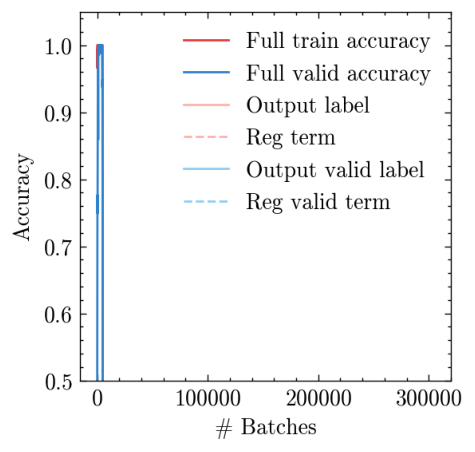

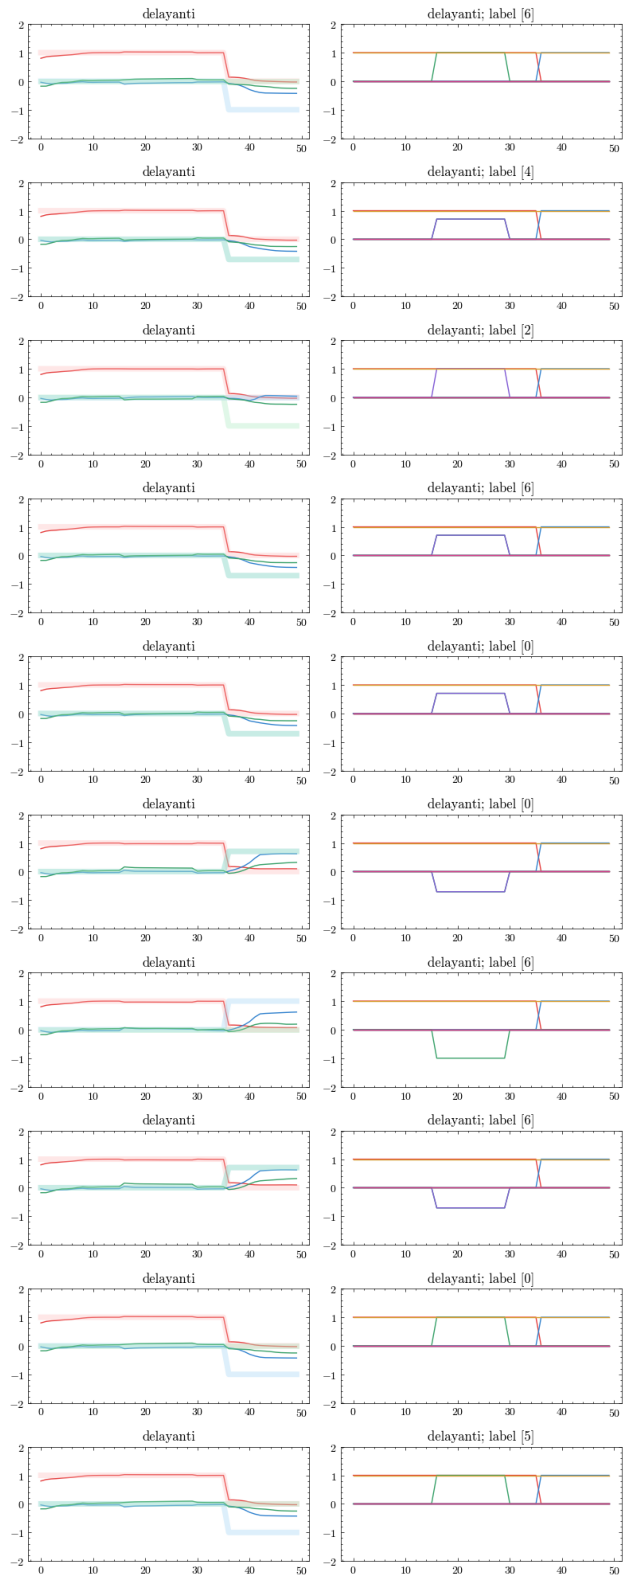

In [32]:
from pathlib import Path
from PIL import Image

def find_pngs_with_components(root, components, recursive=True, case_sensitive=False):
    """
    Return a list of Paths to .png files whose *filenames* contain all substrings in `components`.
    """
    root = Path(root)
    if not case_sensitive:
        components = [c.lower() for c in components]

    candidates = root.rglob("*.png") if recursive else root.glob("*.png")
    matches = []
    for p in candidates:
        name = p.name if case_sensitive else p.name.lower()
        if all(c in name for c in components):
            matches.append(p)

    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches

def show_image(path, size=(6,6)):
    img = Image.open(path)
    fig, ax = plt.subplots(1,1,figsize=size)
    ax.imshow(img)
    ax.axis('off')
    fig.show()

search_root = "./pretraining/"

components_loss = ["loss", f"seed{seed}"]    
matches_loss = find_pngs_with_components(search_root, components_loss,
                                    recursive=True, case_sensitive=False)
show_image(matches_loss[0])

components_showcase = ["lowD", f"seed{seed}"]    
matches_showcase = find_pngs_with_components(search_root, components_showcase,
                                    recursive=True, case_sensitive=False)
show_image(matches_showcase[0], size=(4*2,4*20))

In [33]:
all_rule_info = final_param['rules_epochs']

In [34]:
final_param.files

['rules_epochs',
 'rules_epochs2',
 'hyp_dict_old',
 'hyp_dict',
 'all_rules',
 'Ms_orig_stage1',
 'hs_stage1',
 'bs_stage1',
 'xs_stage1',
 'Ms_orig_stage2',
 'hs_stage2',
 'bs_stage2',
 'xs_stage2']

In [35]:
stage1_output.files

['test_input_np',
 'net_out_stage1_final',
 'test_output_np',
 'rules_epochs',
 'task_params',
 'test_task']

In [36]:
stage2_output.files

['test_input_np',
 'net_out_final',
 'test_output_np',
 'rules_epochs2',
 'task_params',
 'test_task']

In [37]:
len(stage2_output["test_task"])

50

In [38]:
test_task = stage1_output["test_task"]
stage1_op = final_param["hs_stage1"]
stage1_m_op = final_param["Ms_orig_stage1"]
stage2_op = final_param["hs_stage2"]
stage2_m_op = final_param["Ms_orig_stage2"]

stage1_rules_epochs = stage1_output["rules_epochs"].item()
stage2_rules_epochs = stage2_output["rules_epochs2"].item()

print(f"stage1_rules_epochs: {stage1_rules_epochs}")
print(f"stage2_rules_epochs: {stage2_rules_epochs}")
print(f"stage2_op: {stage2_op.shape}")
print(f"stage2_m_op: {stage2_m_op.shape}")

period_shift = 0

stage1_rules_epochs: {'fdgo': {'fix1': (None, 10), 'stim1': (10, 18), 'go1': (18, 26)}, 'delaygo': {'fix1': (None, 16), 'stim1': (16, 30), 'delay1': (30, 36), 'go1': (36, 50)}}
stage2_rules_epochs: {'delayanti': {'fix1': (None, 16), 'stim1': (16, 30), 'delay1': (30, 36), 'go1': (36, 50)}}
stage2_op: (50, 50, 200)
stage2_m_op: (50, 50, 200, 200)


In [50]:
def period_slice(op, epochs, name, key, *, shift=0, mask=None):
    """Return op restricted to [start+shift:end] along time, with optional boolean mask on trials."""
    start, end = epochs[name][key]
    if mask is not None:
        op = op[mask, :, :]
    return op[:, start + shift:end, :]

# trial masks for stage 1
mask0 = (test_task == 0)
mask1 = (test_task == 1)

# ---- stimulus period ----
test_task_0_stim     = period_slice(stage1_op,   stage1_rules_epochs, stage1_name1, "stim1", mask=mask0)
test_task_final_stim = period_slice(stage2_op,   stage2_rules_epochs, final_name,   "stim1")

# modulation counterparts (stim)
test_task_0_stim_m     = period_slice(stage1_m_op, stage1_rules_epochs, stage1_name1, "stim1", mask=mask0)
test_task_final_stim_m = period_slice(stage2_m_op, stage2_rules_epochs, final_name,   "stim1")

# ---- go period ----
test_task_1_go     = period_slice(stage1_op,   stage1_rules_epochs, stage1_name2, "go1", shift=period_shift, mask=mask1)
test_task_final_go = period_slice(stage2_op,   stage2_rules_epochs, final_name,   "go1", shift=period_shift)

# modulation counterparts (go)
test_task_1_go_m     = period_slice(stage1_m_op, stage1_rules_epochs, stage1_name2, "go1", shift=period_shift, mask=mask1)
test_task_final_go_m = period_slice(stage2_m_op, stage2_rules_epochs, final_name,   "go1", shift=period_shift)

assert test_task_0_stim.shape[-1] == test_task_final_stim.shape[-1] == N
assert test_task_1_go.shape[-1] == test_task_final_go.shape[-1] == N

print(test_task_0_stim.shape, test_task_final_stim.shape)
print(test_task_1_go.shape, test_task_final_go.shape)
print(test_task_0_stim_m.shape, test_task_final_stim_m.shape)
print(test_task_1_go_m.shape, test_task_final_go_m.shape)

(50, 8, 200) (50, 14, 200)
(50, 14, 200) (50, 14, 200)
(50, 8, 200, 200) (50, 14, 200, 200)
(50, 14, 200, 200) (50, 14, 200, 200)


In [53]:
def pca_cross_variance_featurewise(X, Y, n_components=None, plot=True, center_on="X", 
                                   X_up=20, name="", datatype="hidden"):
    """
    PCA on features (last axis) of X; project Y onto X's PCs.
    center_on: "X" (default) subtract X's mean from Y; or "Y" subtract Y's mean.
    Returns: evr_X, cev_X, evr_Y_using_X, cev_Y_using_X, pca
    """
    if datatype == "hidden": 
        X2d = X.reshape(-1, X.shape[-1])
        Y2d = Y.reshape(-1, Y.shape[-1])
        
    elif datatype == "modulation": 
        # Under the current design, the modulation matrix should be squared
        assert X.shape[-1] == X.shape[-2] 
        X2d = X.reshape(-1, X.shape[-1] * X.shape[-2])
        Y2d = Y.reshape(-1, Y.shape[-1] * Y.shape[-2])
    else:
        raise TypeError("datatype not valid")

    assert X2d.shape[1] == Y2d.shape[1], "X and Y must share the same feature dimension (last axis)."
    pca = PCA(n_components=n_components)
    pca.fit(X2d)

    evr_X = pca.explained_variance_ratio_
    cev_X = np.cumsum(evr_X)

    if center_on == "X":
        Y_centered = Y2d - pca.mean_
    elif center_on == "Y":
        Y_centered = Y2d - Y2d.mean(axis=0, keepdims=True)
    else:
        raise ValueError('center_on must be "X" or "Y"')

    Y_proj = Y_centered @ pca.components_.T

    var_total_Y = np.var(Y_centered, axis=0, ddof=0).sum()
    if var_total_Y == 0:
        evr_Y_using_X = np.zeros(pca.components_.shape[0])
    else:
        var_per_pc_Y = np.var(Y_proj, axis=0, ddof=0)
        evr_Y_using_X = var_per_pc_Y / var_total_Y
    cev_Y_using_X = np.cumsum(evr_Y_using_X)

    if plot:
        xs = np.arange(1, len(evr_X) + 1)
        # Scree
        fig, ax = plt.subplots(2,1,figsize=(5,3*2))
        ax[0].plot(xs, evr_X, color=c_vals[0], marker='o', label='X (fit)')
        ax[0].plot(xs, evr_Y_using_X, color=c_vals[1], marker='o', label='Y (using X PCs)')
        ax[0].set_xlabel('# PCs'); ax[0].set_ylabel('Variance Explained (per PC)')
        ax[0].set_title('Scree Plot (Feature-wise PCA)')
        ax[0].set_xlim(0, X_up)
        ax[0].legend()

        ax[1].plot(xs, cev_X, color=c_vals[0], marker='o', label='X (fit)')
        ax[1].plot(xs, cev_Y_using_X, color=c_vals[1], marker='o', label='Y (using X PCs)')
        ax[1].set_xlabel('# PCs'); ax[1].set_ylabel('Cumulative Variance Explained')
        ax[1].set_title('Cumulative Variance Explained')
        ax[1].set_xlim(0, X_up)
        ax[1].set_ylim(0, 1.05)
        ax[1].legend()
        fig.tight_layout()
        fig.savefig(f"./pretraining_analysis/{name}_pca.png")

    return evr_X, cev_X, evr_Y_using_X, cev_Y_using_X, pca


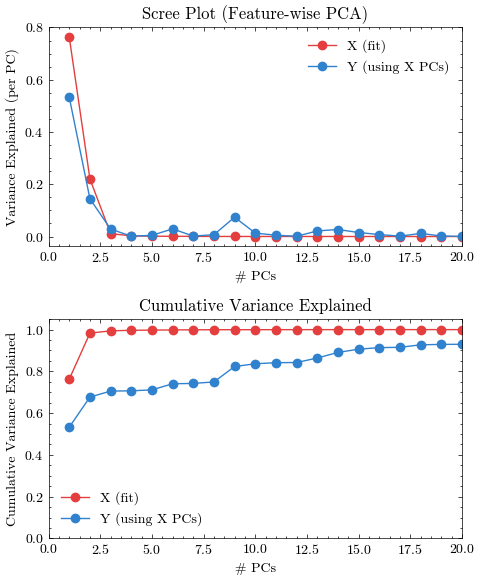

In [45]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_0_stim, test_task_final_stim, 
                                                                   n_components=N, plot=True, center_on="X", 
                                                                   X_up=20, name=f"{checkname}_stimulus", datatype="hidden")

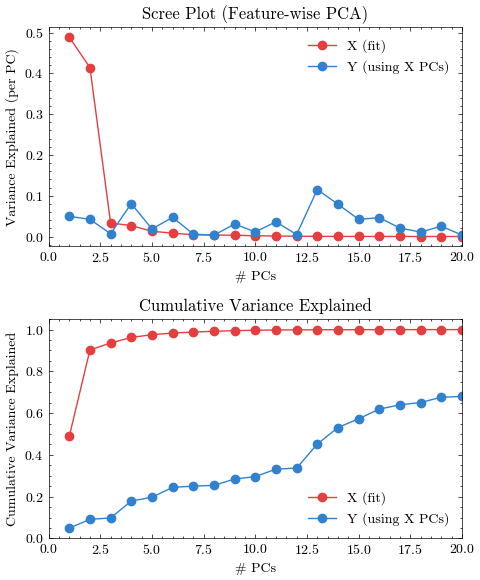

In [46]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_1_go, test_task_final_go, 
                                                                   n_components=N, plot=True, center_on="X", 
                                                                   X_up=20, name=f"{checkname}_response", datatype="hidden")

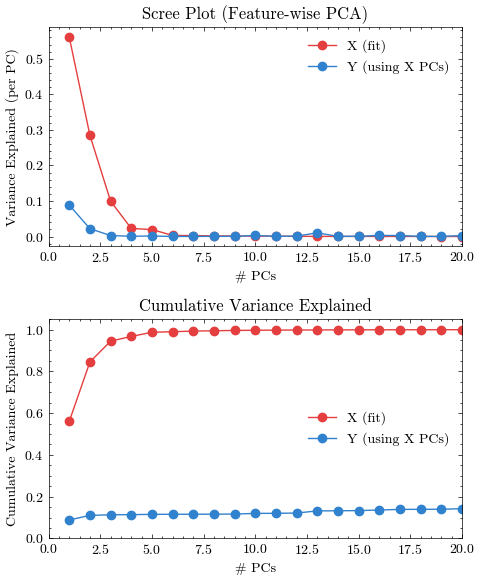

In [54]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_0_stim_m, test_task_final_stim_m, 
                                                                   n_components=N, plot=True, center_on="X", 
                                                                   X_up=20, name=f"{checkname}_stimulus", datatype="modulation")

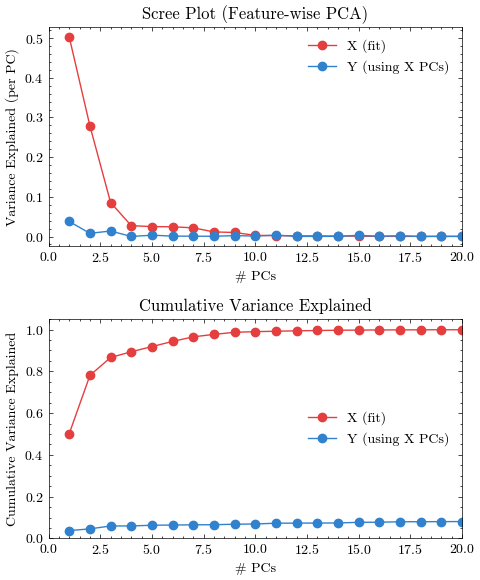

In [55]:
evr_X, cev_X, evr_Yx, cev_Yx, pca = pca_cross_variance_featurewise(test_task_1_go_m, test_task_final_go_m, 
                                                                   n_components=N, plot=True, center_on="X", 
                                                                   X_up=20, name=f"{checkname}_stimulus", datatype="modulation")